# WeatherPy
----
The goal of this project is to select 500+ random locations across the globe, collect weather conditions using OpenWeatherMap, and analyze global trends in the data.

When using the free OpenWeatherMap API, retrieving current weather is straightforward. However, weather conditions at a single point in time are not ideal for characterizing global weather patterns. Weather can be highly variable throughout the day, and conditions will be biased by the local time of day (e.g., noon versus midnight). OpenWeatherMap also allows for querying weather conditions recorded during the previous five days, though only one day can be retrieved per call and the daily call limit for free accounts is 1,000. Based on the limitations, I configured my project to retrieve 24 hours of data for each location, using midnight one day prior to script execution (i.e., yesterday) for all locations. This ensures that the same 24-hour period is used for all locations (regardless of time zone), and that a full 24 hours of data are available. I then calculated the maximum and minimum for temperature, and the 24-hour mean for other weather parameters.

In the next analysis (VacationPy), one of the goals is to screen the list of random cities for potential vacation spots using ideal weather conditions. I know from experience that the daily range in temperature is important to me. I also know that relative humidity is not a good indicator of my comfort level in humid climates, while dew point is an excellent indicator. I start feeling uncomfortable when dew point reaches 65<sup>o</sup>, and I'm completely miserable at 72<sup>o</sup> and higher. As a result, I included minimum and maximum daily temperature and mean daily dew point in my selected meteorological measures.

## Initialize Script

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as st
import json
import requests
import traceback
from time import sleep 
from api_keys import owm_key
from os import stat

## Generate Cities List

This script uses 3GeoNames to generate random locations across the globe. Their API offers an option to preselect a location over or proximal to land, thus avoiding the 71% of global locations over water. The return dictionary includes the name of the nearest location name (usually a town or city) and associated data (including country, lat/lon, distance from random lat/lon, elevation, etc.). In many cases the nearest location values are blank (likely an unpopulated/wilderness area). When this occurs, the location is discarded and the process is repeated.

When a location with data is identified, the lat and lon are then passed to the OpenWeatherMap Geocoding API to find the nearest location in the OpenWeatherMap database. Sometimes OpenWeatherMap returns an empty JSON response, which indicates (I assume) that the 3GeoNames location is too far from an OpenWeatherMap location to qualify. The Geocoding API documentation does not discuss a proximity requirement; regardless of the reason, the location for empty OpenWeatherMap responses is discarded, and the process is repeated.

If the OpenWeatherMap Geocoding API call is successful, the city/location name, country, and lat/lon are stored in a DataFrame. The process is repeated until 600 random locations have been generated, and the results are exported to a CSV file.

In [125]:
# Use https://3geonames.org/api to select random locations globally over land
#    Response includes nearest city, county and corresponding lat/long
#    Free API, no key needed
geoname_url = 'https://api.3geonames.org/?randomland=yes&json=1'
geoname_key = ['city','state','latt','longt']

# OpenWeatherMap geocoding API, reverse lookup
# http://api.openweathermap.org/geo/1.0/reverse?lat={lat}&lon={lon}&limit={limit}&appid={API key}
owm_geo_url = 'http://api.openweathermap.org/geo/1.0/reverse?'
city_fields = ['name','country','lat','lon']

# Error tracking log
log = ['***** LOG *****']

# Initialize variables
df_cities = pd.DataFrame(columns=city_fields)
count = 0

# Loop to retrieve locations with a named place
while count < 600:
    # Obtain random location over land
    geoname_resp = requests.get(geoname_url).json()
    random_loc = [geoname_resp['nearest'][x] for x in geoname_key]
    
    # Discard location and repeat while loop unless 'name','country','lat','lon' are all defined
    if min(len(x) for x in random_loc) == 0:
        continue
    
    # Set API params for OpenWeatherMap geocoding API and query API
    owm_geo_params = {'appid': owm_key,
                     'lat': random_loc[2],
                     'lon': random_loc[3],
                     'limit': '1'}
    owm_geo_resp = requests.get(owm_geo_url, params=owm_geo_params).json()
    
    # Check for non-empty response and proceed, otherwise repeat while loop
    if owm_geo_resp:
        # Store city_fields keys/values
        city_dict = {}
        for field in city_fields:
            city_dict[field] = str(owm_geo_resp[0][field])
            
        # Test if location was already retrieved.
        #      If true, error log it and repeat while loop
        #      If false, append location to DataFrame, increment counter, and send location to print log
        if not df_cities.eq(city_dict).all(axis=1).any():
            df_cities = df_cities.append(city_dict, ignore_index=True)
            count += 1
            print(f"{count}. {city_dict['name']}, {city_dict['country']}, {city_dict['lat']}, {city_dict['lon']}")
        else:
            log.append(f"Duplicate city: {city_dict}")
    
    # OpenWeatherMap geocoding API requirement
    sleep(1)

print()

# Print error report
log.append('*** END LOG ***')
print('\n'.join(log))
print()

# Save location list to csv and display DataFrame summary
df_cities.to_csv('output/random_city_list.csv', index=False)
df_cities

1. Ahonglukumu, CN, 39.1937, 77.326
2. Akbulak, RU, 51.002, 55.6174
3. Sanmeng, CN, 22.8912, 102.4106
4. Yabebyry, PY, -27.3793, -57.1654
5. Canindé, BR, -4.3589, -39.3117
6. Almas, BR, -11.5681, -47.1703
7. Am Timan, TD, 11.0537, 20.4317
8. Курейка, RU, 66.4669, 87.1715
9. Gran Quivira, US, 34.2637, -106.102
10. Pinamalayan, PH, 13.0357, 121.4884
11. Тахтоямск, RU, 60.1973, 154.6804
12. Suqiaoxiang, CN, 28.586, 116.9291
13. Húsavík, IS, 66.0449, -17.3389
14. Zams, AT, 47.1955, 10.5458
15. Kolka, LV, 57.75, 22.5833
16. Murphy, US, 43.2169, -116.5511
17. Tolimán, MX, 20.9167, -99.9333
18. Jetpur, IN, 22.35, 73.8333
19. Mouila, GA, -1.8685, 11.0559
20. Pozo Bertbeder, AR, -26.4099, -64.3371
21. Santa Fe, BR, -2.9093, -67.0568
22. Villa Ocampo, MX, 26.4412, -105.5068
23. Nyarubanga, TZ, -4.2626, 29.9659
24. Ruwan Rana, NG, 12.2012, 5.67
25. Imperatriz, BR, -5.5269, -47.4781
26. Filinga Sekenoma, NG, 7.25, 11.75
27. Seba Beach, CA, 53.5501, -114.7354
28. Moro, US, 45.484, -120.7312
29. DeR

,name,country,lat,lon
0,Ahonglukumu,CN,39.1937,77.326
1,Akbulak,RU,51.002,55.6174
2,Sanmeng,CN,22.8912,102.4106
3,Yabebyry,PY,-27.3793,-57.1654
4,Canindé,BR,-4.3589,-39.3117
...,...,...,...,...
595,Manziliya,IQ,32.4036,47.0039
596,Ksenyevka,RU,53.5598,118.7341
597,Yulin,CN,40.9925,125.9376
598,Dehi,AF,35.9571,67.2694


## Pull Weather Data

In [126]:
# OpenWeatherMap One Call API limits: 60 calls per minute, 1,000 calls per day
# https://api.openweathermap.org/data/2.5/onecall/timemachine?lat={lat}&lon={lon}&dt={time}&appid={API key}
owm_hist_url = 'https://api.openweathermap.org/data/2.5/onecall/timemachine?'

# Generate Unix date for yesterday relative to script execution
#     This is used to allow retrieval of an entire day's worth of hourly values during
#     the same 24-hour period regardless of time zone
yest_dt = dt.datetime.combine(dt.date.today() - dt.timedelta(days=1), dt.time())
yest_stamp = int(dt.datetime.timestamp(yest_dt))

# Initialize variables
met_vars = ['clouds','dew_point','humidity','temp','wind_speed']
df_met_vars = ['clouds','dew_point','humidity','max_temp','min_temp','wind_speed']
df_results_cols = city_fields + df_met_vars
df_results = pd.DataFrame(columns=df_results_cols)
count = 0

# Error tracking log
log2 = ['***** LOG2 *****']

# Retrieve hourly meteorological data for each location
for row in df_cities.to_dict(orient="records"):
    
    # Set API params for OpenWeatherMap recent historical weather data API
    owm_hist_params = {'appid': owm_key,
                    'lat': row['lat'],
                    'lon': row['lon'],
                    'dt': yest_stamp,
                    'units': 'imperial'}
    
    # Code does not fail in testing but better safe than sorry
    try:
        owm_hist_response = requests.get(owm_hist_url, params=owm_hist_params).json()
        
        # Each hour stored sequentially in a list of dictionaries
        hourly_met = owm_hist_response['hourly']
        num_hr = len(hourly_met)
        if num_hr < 24:      # Error log in case 24 sets of observations not given
            log.append(f"Warning: JSON hourly report has {num_hr} values for {row['name']}, {row['country']}")
        
        # Reset storage dictionay for lists of hourly values. 
        #    Dictionary comprehension needed so each empty list is a separate object.
        hourly_vals = {k:[] for k in met_vars}
        
        # Store hourly values
        for i in range(num_hr):
            for var in met_vars:
                hourly_vals[var].append(hourly_met[i][var])
        
        # Process hourly values into daily representations.
        #     Min and max for temperature, means for everything else.
        daily_met = {}
        for var in met_vars:
            if var == 'temp':
                daily_met['max_temp'] = round(max(hourly_vals[var]),1)
                daily_met['min_temp'] = round(min(hourly_vals[var]),1)
            else:
                daily_met[var] = round((sum(hourly_vals[var]) / num_hr),1)
        
        # Store output in DataFrame, increment count, and send results to print log
        output = row | daily_met
        df_results = df_results.append(output, ignore_index=True)
        count += 1
        print(f"{count}. {output['name']}, {output['country']}, {output['lat']}, {output['lon']}: "
                f"CL {output['clouds']}  DP {output['dew_point']}  RH {output['humidity']}  Tmax {output['max_temp']}  "
                f"Tmin {output['min_temp']}  WS {output['wind_speed']}")
        
        # OpenWeatherMap requirement
        sleep(1)
    
    # Print failures and continue processing locations
    except Exception as e:
        print(f"\n******************** ERROR at count = {count} ********************\n{e}\n")
        traceback.print_exc()
        continue
        
print()

# Print error report
log2.append('*** END LOG2 ***')
print('\n'.join(log2))

# Save results  list to csv and display DataFrame summary
df_results.to_csv('output/results.csv', index=False)
df_results


1. Ahonglukumu, CN, 39.1937, 77.326: CL 63.0  DP 43.5  RH 19.2  Tmax 102.2  Tmin 82.6  WS 9.9
2. Akbulak, RU, 51.002, 55.6174: CL 23.8  DP 44.2  RH 37.8  Tmax 81.7  Tmin 59.3  WS 8.9
3. Sanmeng, CN, 22.8912, 102.4106: CL 97.4  DP 68.3  RH 93.9  Tmax 77.6  Tmin 65.2  WS 1.7
4. Yabebyry, PY, -27.3793, -57.1654: CL 1.2  DP 25.2  RH 43.3  Tmax 55.9  Tmin 38.1  WS 8.9
5. Canindé, BR, -4.3589, -39.3117: CL 28.8  DP 64.1  RH 64.2  Tmax 96.3  Tmin 69.3  WS 5.0
6. Almas, BR, -11.5681, -47.1703: CL 0.0  DP 43.7  RH 31.0  Tmax 95.8  Tmin 65.5  WS 2.8
7. Am Timan, TD, 11.0537, 20.4317: CL 99.4  DP 70.4  RH 86.6  Tmax 82.5  Tmin 70.1  WS 3.9
8. Курейка, RU, 66.4669, 87.1715: CL 99.2  DP 49.6  RH 85.9  Tmax 57.6  Tmin 49.0  WS 6.1
9. Gran Quivira, US, 34.2637, -106.102: CL 69.1  DP 50.8  RH 52.7  Tmax 82.7  Tmin 60.3  WS 5.0
10. Pinamalayan, PH, 13.0357, 121.4884: CL 95.5  DP 73.6  RH 74.5  Tmax 89.9  Tmin 78.7  WS 5.1
11. Тахтоямск, RU, 60.1973, 154.6804: CL 79.5  DP 41.5  RH 63.0  Tmax 62.0  Tmin 

,name,country,lat,lon,clouds,dew_point,humidity,max_temp,min_temp,wind_speed
0,Ahonglukumu,CN,39.1937,77.326,63.0,43.5,19.2,102.2,82.6,9.9
1,Akbulak,RU,51.002,55.6174,23.8,44.2,37.8,81.7,59.3,8.9
2,Sanmeng,CN,22.8912,102.4106,97.4,68.3,93.9,77.6,65.2,1.7
3,Yabebyry,PY,-27.3793,-57.1654,1.2,25.2,43.3,55.9,38.1,8.9
4,Canindé,BR,-4.3589,-39.3117,28.8,64.1,64.2,96.3,69.3,5.0
...,...,...,...,...,...,...,...,...,...,...
595,Manziliya,IQ,32.4036,47.0039,0.0,37.0,10.2,118.7,97.1,23.7
596,Ksenyevka,RU,53.5598,118.7341,63.9,57.3,90.6,67.3,54.1,2.7
597,Yulin,CN,40.9925,125.9376,91.1,73.1,77.5,96.2,72.2,2.3
598,Dehi,AF,35.9571,67.2694,0.0,39.2,24.6,91.2,69.3,6.5


## Import Results and Characterize Data

In [7]:
# Import results from CSV, check data types, and show DataFrame summary
df_weath = pd.read_csv('output/results.csv')
print(df_weath.dtypes)
df_weath

name           object
country        object
lat           float64
lon           float64
clouds        float64
dew_point     float64
humidity      float64
max_temp      float64
min_temp      float64
wind_speed    float64
dtype: object


,name,country,lat,lon,clouds,dew_point,humidity,max_temp,min_temp,wind_speed
0,Ahonglukumu,CN,39.1937,77.3260,63.0,43.5,19.2,102.2,82.6,9.9
1,Akbulak,RU,51.0020,55.6174,23.8,44.2,37.8,81.7,59.3,8.9
2,Sanmeng,CN,22.8912,102.4106,97.4,68.3,93.9,77.6,65.2,1.7
3,Yabebyry,PY,-27.3793,-57.1654,1.2,25.2,43.3,55.9,38.1,8.9
4,Canindé,BR,-4.3589,-39.3117,28.8,64.1,64.2,96.3,69.3,5.0
...,...,...,...,...,...,...,...,...,...,...
595,Manziliya,IQ,32.4036,47.0039,0.0,37.0,10.2,118.7,97.1,23.7
596,Ksenyevka,RU,53.5598,118.7341,63.9,57.3,90.6,67.3,54.1,2.7
597,Yulin,CN,40.9925,125.9376,91.1,73.1,77.5,96.2,72.2,2.3
598,Dehi,AF,35.9571,67.2694,0.0,39.2,24.6,91.2,69.3,6.5


### Show plot of random locations

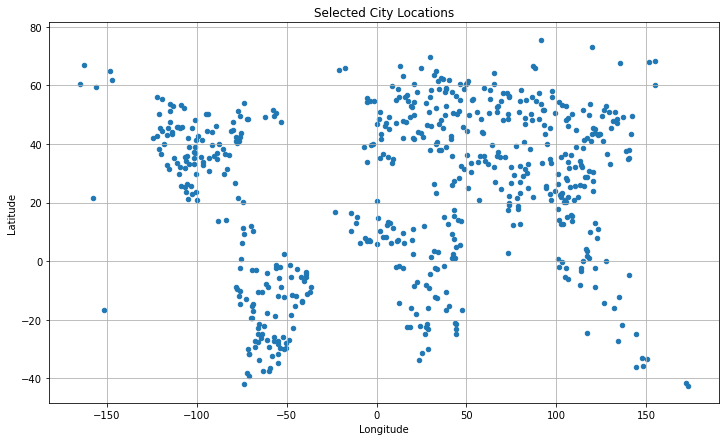

In [8]:
ax = df_weath.plot.scatter(x='lon', y='lat', grid=True, figsize=(12,7), title='Selected City Locations', xlabel='Longitude', ylabel='Latitude')
ax.figure.savefig('output/CityLocationMap.png', dpi=100)

### Show Histograms of City Count by Latitude and Longitude

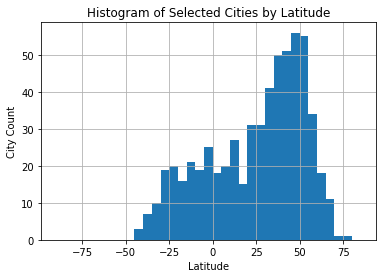

In [47]:
bins = np.arange(-90,90,5)
axarr = df_weath.hist(column='lat', bins=bins, sharex=True, sharey=False)
plt.title('Histogram of Selected Cities by Latitude')
for ax in axarr.flatten():
    ax.set_xlabel("Latitude")
    ax.set_ylabel("City Count")
plt.savefig('output/CityHistogram_Lat.png', dpi=100)

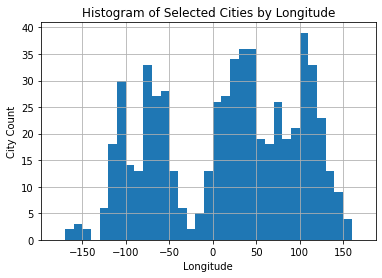

In [48]:
bins2 = np.arange(-180,180,10)
axarr = df_weath.hist(column='lon', bins=bins2, sharex=True, sharey=False)
plt.title('Histogram of Selected Cities by Longitude')
for ax in axarr.flatten():
    ax.set_xlabel("Longitude")
    ax.set_ylabel("City Count")
plt.savefig('output/CityHistogram_Lon.png', dpi=100)

## Display Results Scatter Plots

In [101]:
# Generate date the data were collected for plot legends
#     Retrieve date the results CSV was saved, subtract one day and convert to date string
#     Note that the date represents midlight local time one day before CSV file date, 
#     so the actual date of some locations will differ. However, all data were collected
#     for the same 24-hour time period.
mod_date = dt.date.fromtimestamp(stat('output/results.csv').st_mtime)
prev_date = mod_date - dt.timedelta(days=1)
date_str = prev_date.strftime("%B %d, %Y")


### Global Plots

#### Maximum Temperature vs. Latitude Plot

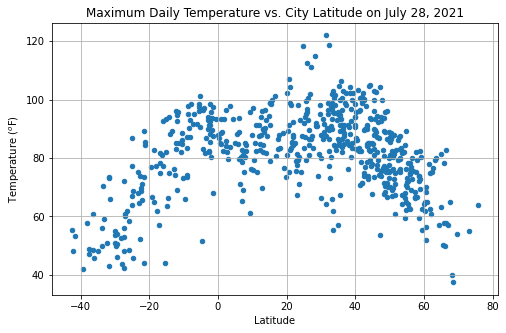

In [82]:
params = {'title': f"Maximum Daily Temperature vs. City Latitude on {date_str}",
         'grid': True,
         'xlabel': 'Latitude',
         'ylabel': 'Temperature ($^o$F)',
         'figsize': (8,5)}
ax = df_weath.plot.scatter(x='lat', y='max_temp', **params)
ax.figure.savefig('output/MaxTemp_Global.png', dpi=100)

Maximum daily temperatures are variable, but decrease towards the poles and increase towards the equator. Data are more concentrated between 30<sup>o</sup> N to 60<sup>o</sup> N, reflecting a larger proportion of the world's land area in North America, Europe, and Asia.

#### Minimum Temperature vs. Latitude Plot

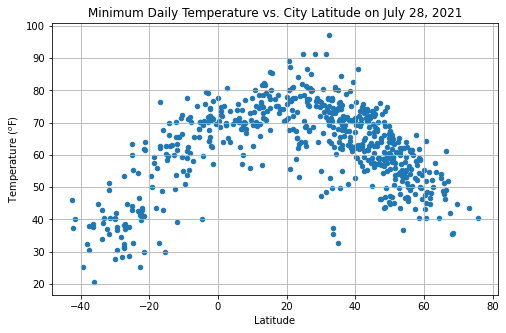

In [83]:
params = {'title': f"Minimum Daily Temperature vs. City Latitude on {date_str}",
         'grid': True,
         'xlabel': 'Latitude',
         'ylabel': 'Temperature ($^o$F)',
         'figsize': (8,5)}
ax = df_weath.plot.scatter(x='lat', y='min_temp', **params)
ax.figure.savefig('output/MinTemp_Global.png', dpi=100)

Minimum daily temperature follows the same pattern as maximum daily temperature, but shows more of a peak in the middle of the distribution. The peak appears to be focused around 10<sup>o</sup> N to 30<sup>o</sup> N. This is due to summertime conditions in the Northern Hemisphere, when the sun's angle of incidence (and radiation intensity) is highest for latitudes in this range.

####  Dew Point vs. Latitude Plot

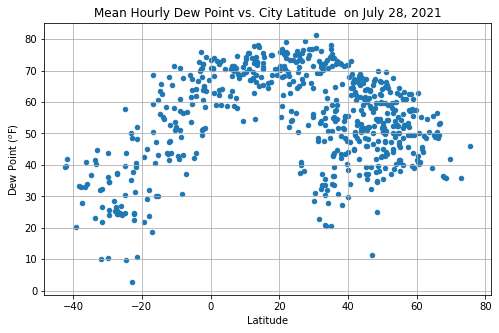

In [84]:
params = {'title': f'Mean Hourly Dew Point vs. City Latitude  on {date_str}',
         'grid': True,
         'xlabel': 'Latitude',
         'ylabel': 'Dew Point ($^o$F)',
         'figsize': (8,5)}
ax = df_weath.plot.scatter(x='lat', y='dew_point', **params)
ax.figure.savefig('output/DewPoint_Global.png', dpi=100)

The distribution of mean hourly dew point is similar to minimum daily temperature, but with greater variability. Dew points are usually lower than the range of daily temperatures in semi-arid and arid climates

#### Relative Humidity vs. Latitude Plot

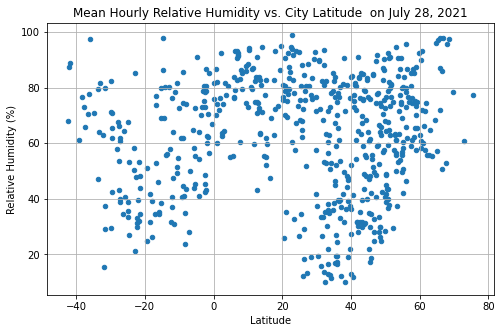

In [85]:
params = {'title': f'Mean Hourly Relative Humidity vs. City Latitude  on {date_str}',
         'grid': True,
         'xlabel': 'Latitude',
         'ylabel': 'Relative Humidity (%)',
         'figsize': (8,5)}
ax = df_weath.plot.scatter(x='lat', y='humidity', **params)
ax.figure.savefig('output/RelHum_Global.png', dpi=100)

As discussed at the beginning of this notebook, relative humidity represents how much of air's water-holding capacity is "filled" at the current temperature. As the gap between temperature and dew point increases, relative humidity decreases, though the degree of change varies with air temperature. The global pattern of relative humidity reflects all these factors.

#### Cloudiness vs. Latitude Plot

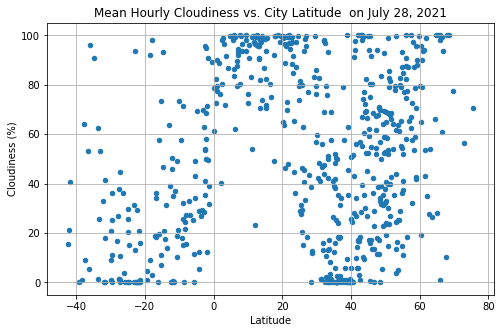

In [86]:
params = {'title': f'Mean Hourly Cloudiness vs. City Latitude  on {date_str}',
         'grid': True,
         'xlabel': 'Latitude',
         'ylabel': 'Cloudiness (%)',
         'figsize': (8,5)}
ax = df_weath.plot.scatter(x='lat', y='clouds', **params)
ax.figure.savefig('output/Cloud_Global.png', dpi=100)

Mean hourly cloudiness is highly variable, but tends to be low in the southern hemisphere and high between 0<sup>o</sup> N and 10<sup>o</sup> N. This could be related to conditions during the day selected for analysis.

#### Wind Speed vs. Latitude Plot

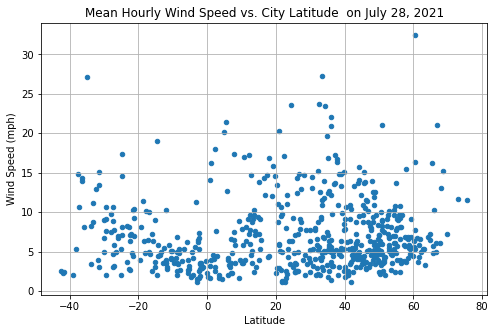

In [87]:
params = {'title': f'Mean Hourly Wind Speed vs. City Latitude  on {date_str}',
         'grid': True,
         'xlabel': 'Latitude',
         'ylabel': 'Wind Speed (mph)',
         'figsize': (8,5)}
ax = df_weath.plot.scatter(x='lat', y='wind_speed', **params)
ax.figure.savefig('output/WindSpeed_Global.png', dpi=100)

Mean hourly wind speed is variable across latitutudes, and appears to show a lognormal distribution clustered at low wind speed.

### Linear Regression

In [88]:
# Create subset DataFrames for each hemisphere
#     While latitude = 0 is unlikely to happen in practice, this is
#     arbitrarily assigned to Southern Hemisphere
df_subset_nh = df_weath.loc[df_weath['lat'] > 0].copy()
df_subset_sh = df_weath.loc[df_weath['lat'] <= 0].copy()

# Create arrays of latitudes for each hemisphere
x_vals_nh = df_subset_nh['lat'].values
x_vals_sh = df_subset_sh['lat'].values

# Find minimum latitide for setting annotation position
x_min_nh = min(x_vals_nh)
x_min_sh = min(x_vals_sh)

# Parameters to create semi-transparent mask around annotations
box_trans = dict(boxstyle='round,pad=0',facecolor='white', edgecolor='white', alpha=0.5)

####  Northern Hemisphere - Maximum Daily Temperature vs. Latitude Linear Regression

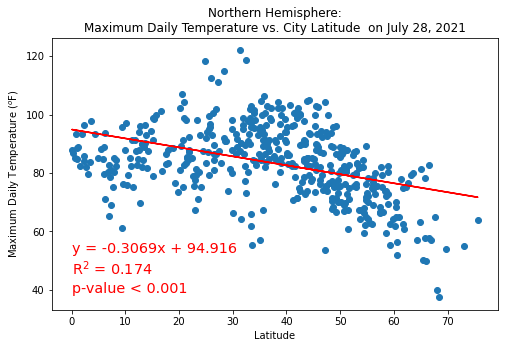

In [89]:
####################### Northern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_nh['max_temp'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_nh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_nh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.18
pos2 = y_min + y_rng * 0.09
pos3 = y_min + y_rng * 0.02

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Northern Hemisphere:\nMaximum Daily Temperature vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Maximum Daily Temperature ($^o$F)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_nh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_nh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_nh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_nh, y_vals)
ax.plot(x_vals_nh, regress_vals, 'r-');
plt.savefig('output/Regr_DewPoint_NorHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) negative relatioship between latitude and maximum daily temperature. However, latitude alone does not explain much of the variation in maximum daily temperature as indicated by the low R<sup>2</sup> value.

####  Southern Hemisphere - Maximum Daily Temperature vs. Latitude Linear Regression

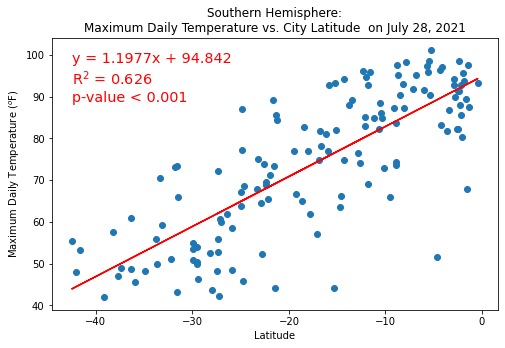

In [90]:
####################### Southern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_sh['max_temp'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_sh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_sh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.95
pos2 = y_min + y_rng * 0.86
pos3 = y_min + y_rng * 0.79

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Southern Hemisphere:\nMaximum Daily Temperature vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Maximum Daily Temperature ($^o$F)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_sh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_sh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_sh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_sh, y_vals)
ax.plot(x_vals_sh, regress_vals, 'r-');
plt.savefig('output/Regr_DewPoint_SouHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) positive relatioship between latitude and maximum daily temperature. Latitude explains much of the variation in maximum daily temperature as indicated by R<sup>2</sup> = 0.626.

####  Northern Hemisphere - Minimum Daily Temperature vs. Latitude Linear Regression

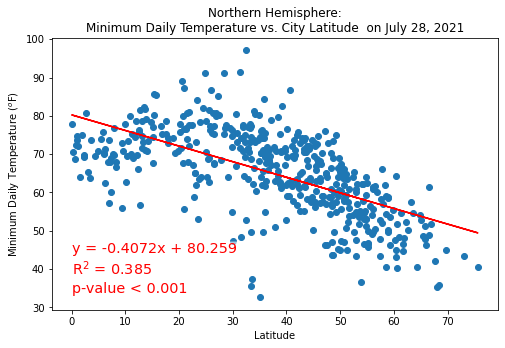

In [91]:
####################### Northern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_nh['min_temp'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_nh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_nh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.18
pos2 = y_min + y_rng * 0.09
pos3 = y_min + y_rng * 0.02

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Northern Hemisphere:\nMinimum Daily Temperature vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Minimum Daily Temperature ($^o$F)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_nh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_nh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_nh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_nh, y_vals)
ax.plot(x_vals_nh, regress_vals, 'r-');
plt.savefig('output/Regr_DewPoint_NorHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) negative relatioship between latitude and minimum daily temperature. However, latitude alone does not explain much of the variation in minimum daily temperature as indicated by the low R<sup>2</sup> value.

####  Southern Hemisphere - Minimum Daily Temperature vs. Latitude Linear Regression

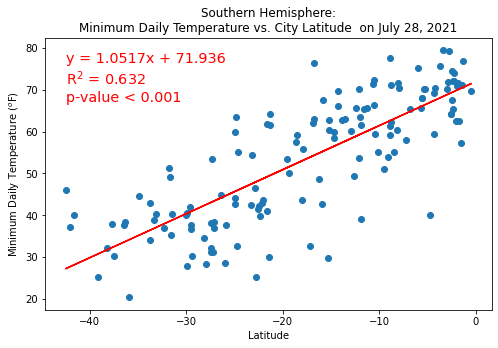

In [92]:
####################### Southern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_sh['min_temp'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_sh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_sh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.95
pos2 = y_min + y_rng * 0.86
pos3 = y_min + y_rng * 0.79

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Southern Hemisphere:\nMinimum Daily Temperature vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Minimum Daily Temperature ($^o$F)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_sh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_sh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_sh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_sh, y_vals)
ax.plot(x_vals_sh, regress_vals, 'r-');
plt.savefig('output/Regr_DewPoint_SouHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) positive relatioship between latitude and minimum daily temperature. Latitude explains much of the variation in minimum daily temperature as indicated by R<sup>2</sup> = 0.632.

####  Northern Hemisphere - Dew Point vs. Latitude Linear Regression

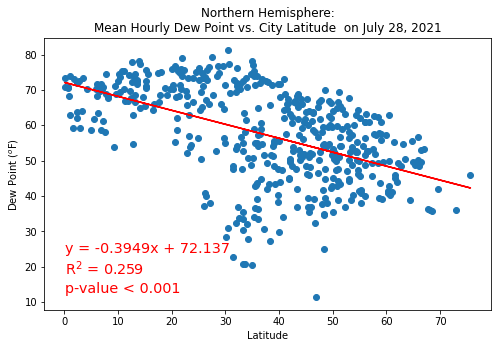

In [93]:
####################### Northern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_nh['dew_point'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_nh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_nh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.18
pos2 = y_min + y_rng * 0.09
pos3 = y_min + y_rng * 0.02

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Northern Hemisphere:\nMean Hourly Dew Point vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Dew Point ($^o$F)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_nh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_nh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_nh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_nh, y_vals)
ax.plot(x_vals_nh, regress_vals, 'r-');
plt.savefig('output/Regr_DewPoint_NorHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) negative relatioship between latitude and mean hourly dew point. However, latitude alone does not explain much of the variation in mean hourly dew point as indicated by the low R<sup>2</sup> value.

####  Southern Hemisphere - Dew Point vs. Latitude Linear Regression

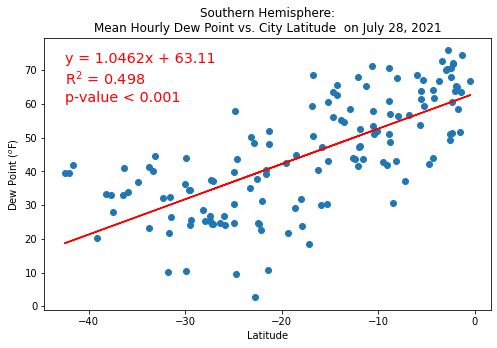

In [94]:
####################### Southern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_sh['dew_point'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_sh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_sh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.95
pos2 = y_min + y_rng * 0.86
pos3 = y_min + y_rng * 0.79

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Southern Hemisphere:\nMean Hourly Dew Point vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Dew Point ($^o$F)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_sh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_sh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_sh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_sh, y_vals)
ax.plot(x_vals_sh, regress_vals, 'r-');
plt.savefig('output/Regr_DewPoint_SouHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) positive relatioship between latitude and mean hourly dew point. Latitude explains some of the variation in mean hourly dew point as indicated by R<sup>2</sup> = 0.498.

####  Northern Hemisphere - Relative Humidity vs. Latitude Linear Regression

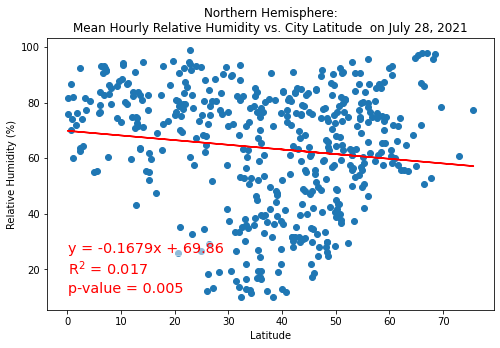

In [95]:
####################### Northern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_nh['humidity'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_nh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_nh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.18
pos2 = y_min + y_rng * 0.09
pos3 = y_min + y_rng * 0.02

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Northern Hemisphere:\nMean Hourly Relative Humidity vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Relative Humidity (%)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_nh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_nh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_nh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_nh, y_vals)
ax.plot(x_vals_nh, regress_vals, 'r-');
plt.savefig('output/Regr_RelHum_NorHem.png', dpi=100)

The regression shows a significant (p-value = 0.005) negative relatioship between latitude and mean hourly relative humidity. However, latitude explains very little of the variation in mean hourly relative humidity as indicated by R<sup>2</sup> = 0.017.

####  Southern Hemisphere - Relative Humidity vs. Latitude Linear Regression

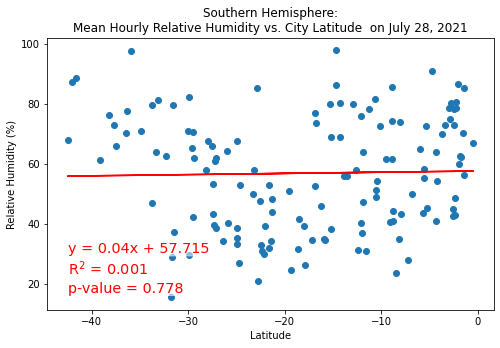

In [96]:
####################### Southern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_sh['humidity'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_sh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_sh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.18
pos2 = y_min + y_rng * 0.09
pos3 = y_min + y_rng * 0.02

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Southern Hemisphere:\nMean Hourly Relative Humidity vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Relative Humidity (%)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_sh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_sh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_sh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_sh, y_vals)
ax.plot(x_vals_sh, regress_vals, 'r-');
plt.savefig('output/Regr_RelHum_SouHem.png', dpi=100)

The regression shows no significant (p-value = 0.778) relatioship between latitude and mean hourly relative humidity.

####  Northern Hemisphere - Cloudiness vs. Latitude Linear Regression

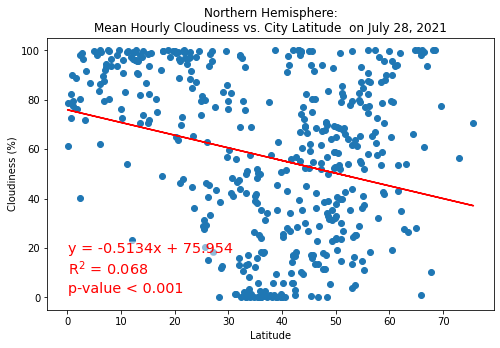

In [97]:
####################### Northern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_nh['clouds'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_nh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_nh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.18
pos2 = y_min + y_rng * 0.09
pos3 = y_min + y_rng * 0.02

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Northern Hemisphere:\nMean Hourly Cloudiness vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Cloudiness (%)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_nh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_nh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_nh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_nh, y_vals)
ax.plot(x_vals_nh, regress_vals, 'r-');
plt.savefig('output/Regr_Cloud_NorHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) negative relatioship between latitude and mean hourly cloudiness. However, latitude explains very little of the variation in mean hourly cloudiness as indicated by R<sup>2</sup> = 0.068.

####  Southern Hemisphere - Cloudiness vs. Latitude Linear Regression

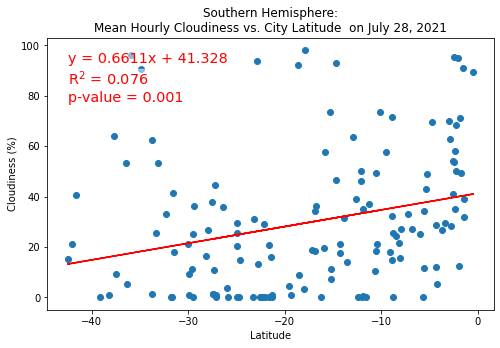

In [98]:
####################### Southern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_sh['clouds'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_sh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_sh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.95
pos2 = y_min + y_rng * 0.86
pos3 = y_min + y_rng * 0.79

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Southern Hemisphere:\nMean Hourly Cloudiness vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Cloudiness (%)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_sh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_sh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_sh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_sh, y_vals)
ax.plot(x_vals_sh, regress_vals, 'r-');
plt.savefig('output/Regr_Cloud_SouHem.png', dpi=100)

The regression shows a significant (p-value = 0.001) positive relatioship between latitude and mean hourly cloudiness. However, latitude explains very little of the variation in mean hourly cloudiness as indicated by R<sup>2</sup> = 0.076.

####  Northern Hemisphere - Wind Speed vs. Latitude Linear Regression

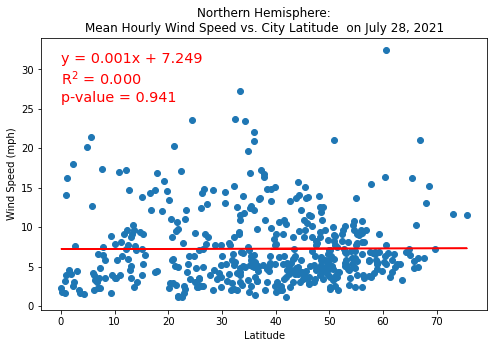

In [99]:
####################### Northern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_nh['wind_speed'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_nh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_nh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.95
pos2 = y_min + y_rng * 0.86
pos3 = y_min + y_rng * 0.79

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Northern Hemisphere:\nMean Hourly Wind Speed vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Wind Speed (mph)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_nh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_nh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_nh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_nh, y_vals)
ax.plot(x_vals_nh, regress_vals, 'r-');
plt.savefig('output/Regr_WindSpeed_NorHem.png', dpi=100)

The regression shows no significant (p-value = 0.941) relatioship between latitude and mean hourly wind speed.

####  Southern Hemisphere - Wind Speed vs. Latitude Linear Regression

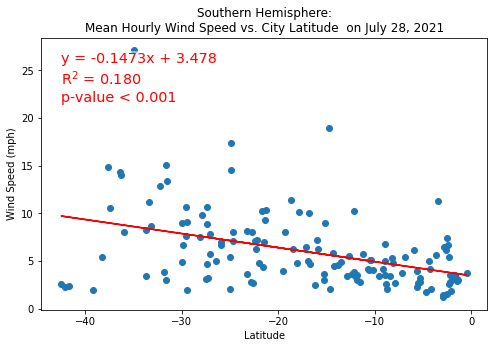

In [100]:
####################### Southern Hemisphere template ############################
# Generate values array for meteorological measure
y_vals = df_subset_sh['wind_speed'].values               #<---------- update var name

# Linear regression model
(slope, intercept, r, p, se) = st.linregress(x_vals_sh, y_vals)

# Make data series for regression plot
regress_vals = x_vals_sh * slope + intercept

# Create annotation strings
ann1 = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,3))
ann2 = f"R$^2$ = {r*r:.3f}"
if round(p,3) < 0.001:
    ann3 = 'p-value < 0.001'
else:
    ann3 = f'p-value = {round(p,3)}'

# Set annotation positions
y_min = min(y_vals)
y_rng = max(y_vals) - y_min
pos1 = y_min + y_rng * 0.95
pos2 = y_min + y_rng * 0.86
pos3 = y_min + y_rng * 0.79

# Generate figure
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title(f'Southern Hemisphere:\nMean Hourly Wind Speed vs. City Latitude  on {date_str}')         #<---------- update var text
ax.set_xlabel('Latitude')
ax.set_ylabel('Wind Speed (mph)')                                     #<---------- update var text and units
ax.annotate(ann1, (x_min_sh,pos1), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann2, (x_min_sh,pos2), color='r', fontsize='x-large', bbox=box_trans)
ax.annotate(ann3, (x_min_sh,pos3), color='r', fontsize='x-large', bbox=box_trans)
ax.scatter(x_vals_sh, y_vals)
ax.plot(x_vals_sh, regress_vals, 'r-');
plt.savefig('output/Regr_WindSpeed_SouHem.png', dpi=100)

The regression shows a significant (p-value < 0.001) negative relatioship between latitude and mean hourly wind speed. However, latitude explains little of the variation in mean hourly wind speed as indicated by R<sup>2</sup> = 0.180.